# Intelligent channel hopper demonstration

A new channel hopper that is responsive to the traffic on each Wi-Fi channel is implemented in the sniffer. This channel hopper should be able to sniff more frames from mobile device when compared to sequential constant-rate hopping schemes. Most commercial sniffers either sniff on one specified channel without hopping (Like the sniffer function on Cisco APs) or hop between all channels in a constant rate (Like the WiFi Pineapple).

The effectiveness of each sniffer hopping scheme is determined by the percentage of time spent on each channel with active traffic. A channel is said to have active traffic if there are data frames exchanged for the duration of sniffing. Conversely, only probe request frames from STAs might appear on an inactive channel.

For the sequential channel hopping scheme, the percentage of time spend on each channel is given by $1/n_{ch}$ where $n_{ch}$ is the number of channels. In Hong Kong there are 13 channels on the 2.4GHz band that are legal. In this case the above expression evaluates to $1/13 = 7.69\%$. 

However, most Wi-Fi traffic happens on channels 1, 6 and 11 as only this set of channels are non-overlapping. If the sniffer only hops on these 3 channels, the time spend on each channel increases to $1/3 = 33.3\%$.


In [208]:
from datetime import datetime
import matplotlib.pyplot as plt
from ipywidgets import widget
import re

In [209]:
def load_time_series(file_name):
    d_list = []
    time_offset = None
    with open(file_name) as f:
        for l in f:
            if not len(l):
                # Blank line, ignore
                continue
            if 'hopper' not in l:
                # Sniffed frame output, ignore
                continue
            d = {}
            if not time_offset:
                time_offset = float(l[:17])
            try:
                d["timestamp"] = float(l[:17])-time_offset
            except ValueError:
                # Sometimes this happen as the outputs from the sniffer is corrupted
                continue
            d["message"] = l[18:]
            d_list += [d]
    return d_list

In [210]:
def filter_time_series_hopper(d_list):
    out_list = []
    for l in (d for d in d_list if "next time" in d["message"]):
        try:
            l["channel"] = int(l["message"][21:23])
            l["next_dur"] = int(l["message"].split('gets')[1][1:-4])
        except:
            # Corruption again
            continue
        out_list += [l]
    return out_list

In [211]:
def calculate_hopper_duration_percent(d_list):
    channel_hopping_times = [None]*13
    for d in d_list:
        channel_hopping_times[d["channel"]-1]=d["next_dur"]
        if None not in channel_hopping_times:
            # Calculate percentage
            d["percentage"] = d["next_dur"] / sum(channel_hopping_times)*100
        else:
            d["percentage"] = 0
    return d_list

In [212]:
def plot_time_series_hopper(d_list,loc):
    plt.figure(figsize=(16,16))
    inchart = plt.subplot('211')
    channel_averages = []
    for i in range(1,14):
        plt.plot([d["timestamp"] for d in d_list if d["channel"] == i],[d["next_dur"] for d in d_list if d["channel"] == i],label="Channel %d"%i)
        channel_averages += [sum([d["next_dur"] for d in d_list if d["channel"] == i])/len([d["next_dur"] for d in d_list if d["channel"] == i])]
    inchart.legend()
    inchart.set_xlabel("Time (s)")
    inchart.set_ylabel("Sniff duration (ms)")
    inchart.set_title("Sniff duration of each channel - "+loc)
    avchart = plt.subplot('212')
    for i in range(1,14):
        avchart.plot([d["timestamp"] for d in d_list if d["channel"] == i],[d["percentage"] for d in d_list if d["channel"] == i],label="Channel %d"%i)
    avchart.legend()
    avchart.set_xlabel("Time (s)")
    avchart.set_ylabel("Sniff duration (%)")
    avchart.set_title("Sniff percentage of each channel - "+loc)
    plt.show()

## Normal operation

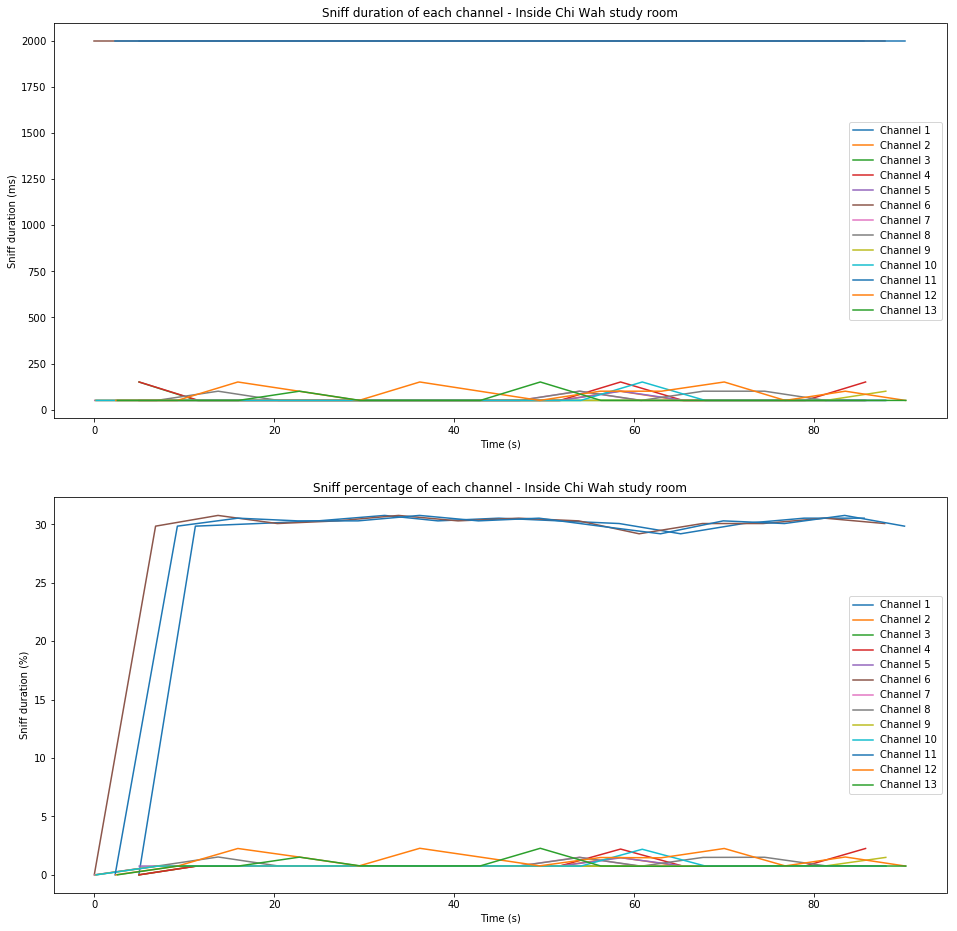

In [213]:
hopper_msg_list = load_time_series("smart_hopping_chiwah_insideroom.log")
hopper_msg_list = filter_time_series_hopper(hopper_msg_list)
hopper_msg_list = calculate_hopper_duration_percent(hopper_msg_list)
plot_time_series_hopper(hopper_msg_list,"Inside Chi Wah study room")

The above charts show the behavior of the hopping algorithm in a stable environment with Wi-Fi communications at channel 1, 6 and 11. The channel hopper adapted to traffic on these 3 channels and assigned a longer sniffing time. Each of the 3 active channels are sniffed for about 30% of the time, totaling 90% for all 3 channels. The remaining ~10% of time is spent on sniffing the remaining channels. These channels are not completely silent either. As seen from the left chart, there are ocassionally a few frames on the inactive channels. 

## More channel hops in

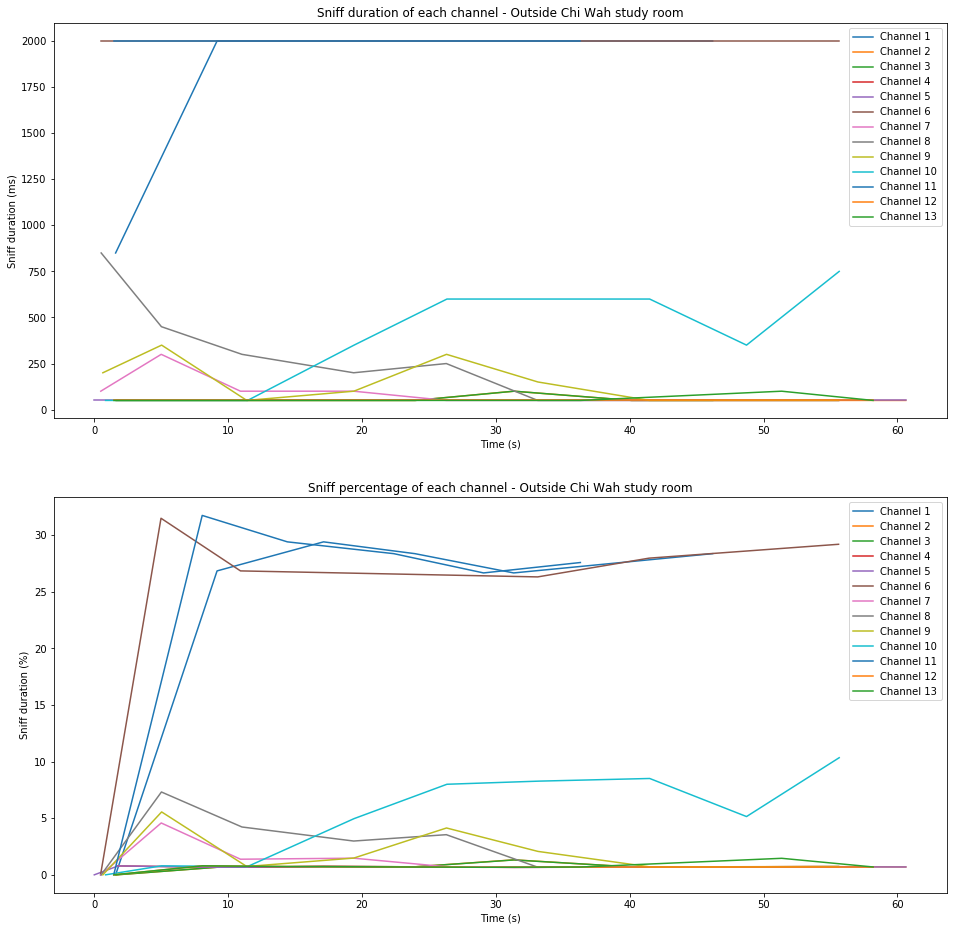

In [214]:
hopper_msg_list = load_time_series("smart_hopping_chiwah_outsideroom.log")
hopper_msg_list = filter_time_series_hopper(hopper_msg_list)
hopper_msg_list = calculate_hopper_duration_percent(hopper_msg_list)
plot_time_series_hopper(hopper_msg_list,"Outside Chi Wah study room")

The above chart shows the sniffer's behavior in a busy environment with tens of devices using Wi-Fi in its vicinity. Apart from the busy channels 1, 6 and 11, it can be seen that channel 10 starts to increase in traffic from t = 20s. As seen from the captured frames chart below, frames are received densely from the 3 busy channels, while frames from channel 10 are relatively sparse.

While more time is allocated to channel 10, the 3 busy channels are still sniffed for the maximum duration of 2s each. Time taken for the sniffer to complete one round of sniffing from all channels is increased.

In [215]:
import re
sniffed_frames = []
with open("smart_hopping_chiwah_outsideroom.log") as f:
    for l in f:
        if re.match('^.*?\d{10} CH\d{2} RI-\d+ \d{2} \d{2}',l):
            frame_line = l[21:]
            sniffed_frames += [frame_line]

In [216]:
# Filter invalid types
validtypes = ['00', # Association request
              '01', # Association response
              '02', # Reassociation request
              '03', # Reassociation response
              '04', # Probe request
              '05', # Probe response
              '08', # Beacon
              '09', # ATIM
              '0a', # Disassociation
              '0b', # Authentication
              '0c', # Deauthentication
              '0d', # Action
              '18', # BlockAckReq
              '19', # BlockAck
              '1a', # PS-Poll
              '1b', # RTS
              '1c', # CTS
              '1d', # Ack
              '1e', # CF-end
              '1f', # CF-end + CF-ack
              '20', # Data
              '21', # Data + CF-ack
              '22', # Data + CF-poll
              '23', # Data + CF-ack + CF-poll
              '24', # Null
              '25', # CF-ack
              '26', # CF-poll
              '27', # CF-ack + CF-poll
              '28', # QoS data
              '29', # QoS data + CF-ack
              '2a', # QoS data + CF-poll
              '2b', # QoS data + CF-ack + CF-poll
              '2c', # QoS null
              '2e', # QoS + CF-poll
              '2f'] # QoS + CF-ack

# Convert lines of frame to Python dictionaries
def sniffer_log_to_dict(sniffer_log: "List[Str]") -> "List[Dict]":
    ret_dicts = []
    last_timestamp = 0
    overflow_counts = 0
    for l in sniffer_log:
        ret_dict = {}
        try:
            this_timestamp = int(l[:10])/1e6
            ret_dict["timestamp"] = this_timestamp
            ret_dict["channel"] = int(l[13:15])
            ret_dict["rssi"] = int(l[18:21])
        except:
            # Corrupted
            continue
        ret_dict["frame_type"] = l[22:24]
        if ret_dict["frame_type"] not in validtypes:
            # Invalid type received, skip it
            continue
        ret_dict["ds_flag"] = l[25:27]
        ret_dict["dest_mac"] = l[28:40]
        ret_dict["src_mac"] = l[41:53]
        ret_dict["addr3"] = l[54:66]
        ret_dict["addr4"] = l[67:79]
        ret_dicts += [ret_dict]
    return ret_dicts

In [228]:
def plot_sniffed_frames(path):
    sniffed_frames = []
    with open(path) as f:
        for l in f:
            if re.match('^.*?\d{10} CH\d{2} RI-\d+ \d{2} \d{2}',l):
                frame_line = l[21:]
                sniffed_frames += [frame_line]
    sniffed_frames = sniffer_log_to_dict(sniffed_frames)
    plt.figure(figsize=(16,8))
    for i in range(1,14):
        sniffed_frames_filtered = [f for f in sniffed_frames if f["channel"] == i]
        plt.scatter([d["timestamp"] for d in sniffed_frames_filtered],[d["rssi"] for d in sniffed_frames_filtered],label="Channel %d"%i)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("RSSI")
    plt.ylim(-100,0)
    plt.title("Frames from different channels")
    plt.savefig("smart_hopping.png")
    plt.show()

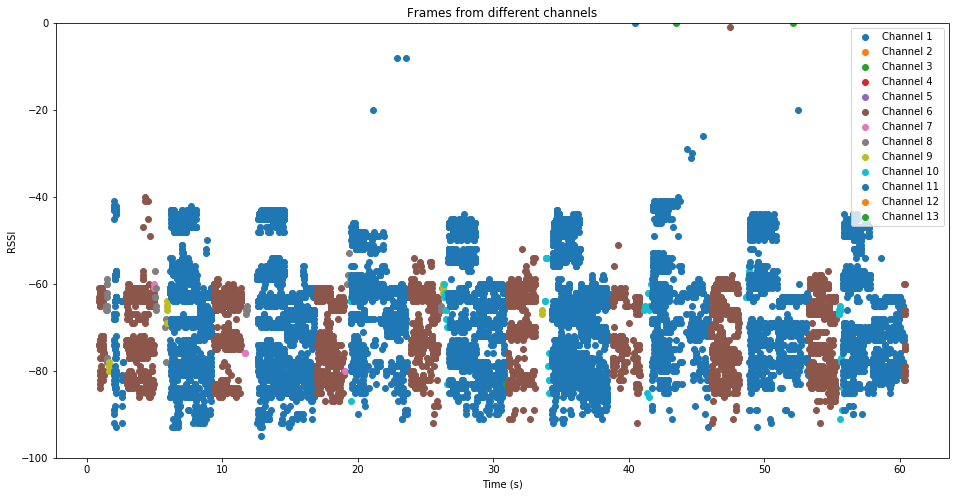

In [229]:
plot_sniffed_frames("smart_hopping_chiwah_outsideroom.log")
fig = plt.gcf()

## Shielded from Wi-Fi frames

The sniffer is taken into and out of a shielded room to see its behavior on APs disappearing and reappearing. At time = 60s, the sniffer is brought out of the shielded room. An immediate increase in sniffing time, starting with channel 6, can be observed. The whole recovery process happens in less than 10s, after which the sniffer spent most of its time sniffing the busy channels 1, 6 and 11.

At time = 90s the sniffer is brought back into the shielded room. After spending 2s on each channel receiving no frames, the sniffer immediately decreased sniffing time for all channels to the minimum of 50 ms. This fast cycle time ensures the sniffer responses quickly when a channel becomes active again.

At time = 120s the sniffer is exposed to the Wi-Fi busy environment again. The recovery behavior can be see through the plot of sniffing time for channel 1 from 120s to 150s. The sniffer increases sniffing time for active channels until the upper limit of 2s.

Afterwards the sniffer is brought about the area, making it receiving varying signal strengths from different APs at other channels. From 150s to 250s different channels are assigned different sniffing times according to the number of frames received on the channel. This verifies the hopper's behavior on adapting sniffing time to the local Wi-Fi environment. 

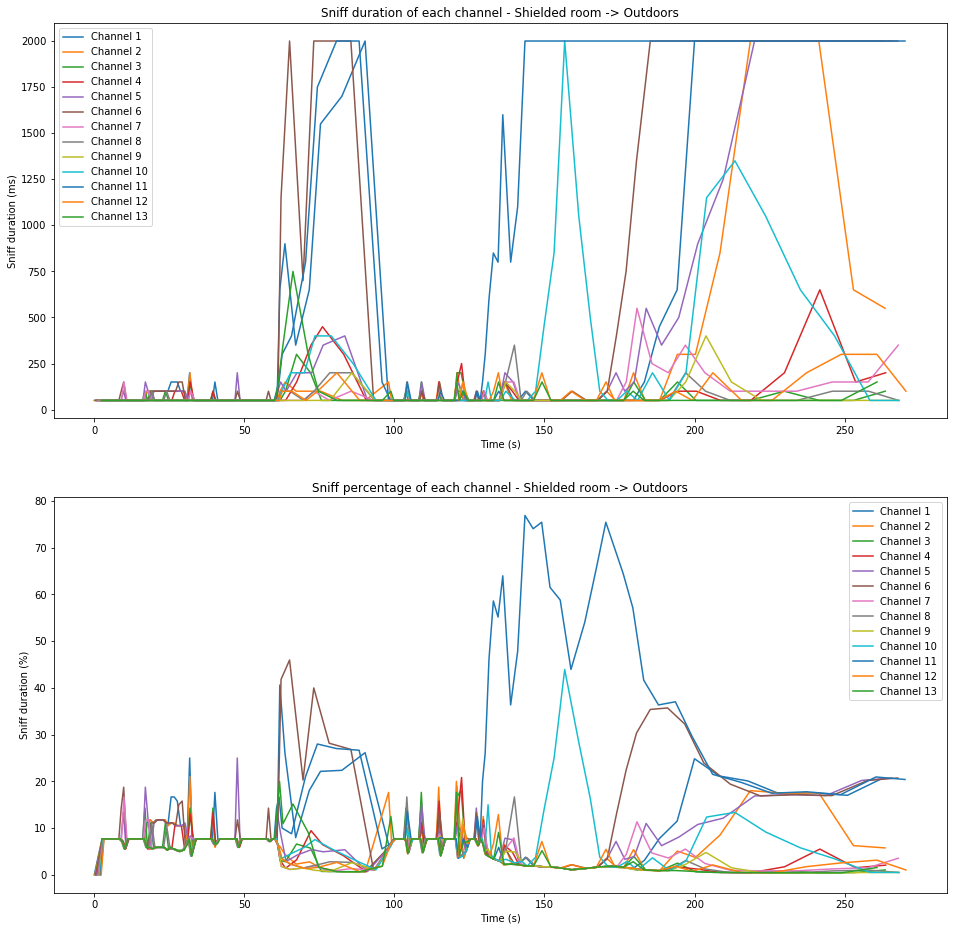

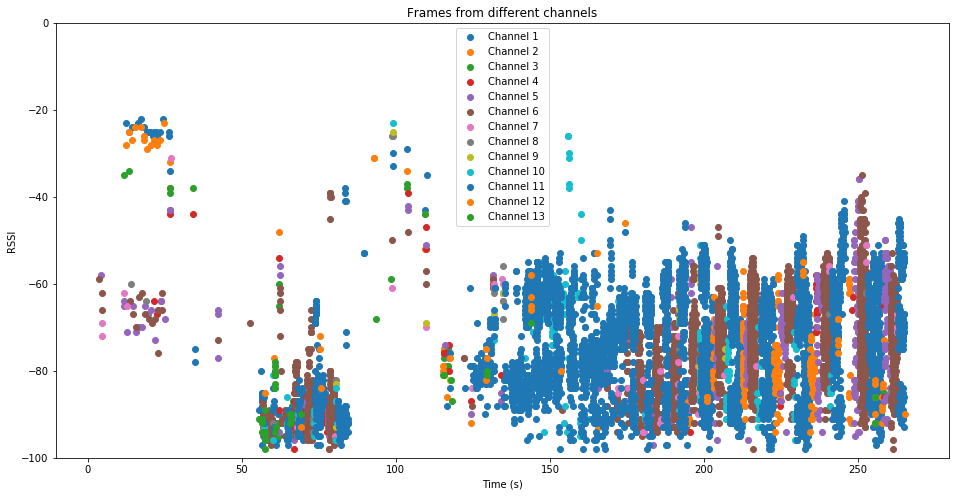

In [219]:
hopper_msg_list = load_time_series("smart_hopping_outdoors_shielded.log")
hopper_msg_list = filter_time_series_hopper(hopper_msg_list)
hopper_msg_list = calculate_hopper_duration_percent(hopper_msg_list)
plot_time_series_hopper(hopper_msg_list,"Shielded room -> Outdoors")
plot_sniffed_frames("smart_hopping_outdoors_shielded.log")

---
To conclude, the smart channel hopper can sniff more effectively than "dumb" sequential hopping schemes. The time spent on each channel depends on the number of active channels. For a typical indoor environment with Wi-Fi coverage, the majority of traffic happens on 3 active channels, 1, 6 and 11. The sniffer spent 30% on each of the busy channels, **4 times more** than a sequential hopping scheme covering all channels.

Although a sequential hopping scheme covering only the 3 active channels provides 33.3% time on each of the busy channels, the proposed smart hopping scheme compensates for this as it can adapt to changing Wi-Fi environment conditions. In the second experiment, the sniffer increased sniffing time on channel 10 in response to an increase in traffic on that channel. Such frames would not have been sniffed by a hopping scheme only looking at channels 1, 6 and 11.

The smart hopper also reallocates time depending on the number of active channels in the vicinity. At t=200s in experiment 3, more than 3 busy channels are received by the sniffer. The sniffer responds by increasing sniffing time on each of the busy channels, making the cycle time longer. This behavior is desired as the sniffer can receive more Wi-Fi frames from busy channels, rather than spending equal time on less busy channels in the sequential case.